In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function

import argparse
import time
import torch
import torch.nn as nn
import torch.nn.parallel

import torch.utils.data
import matplotlib.pyplot as plt
import warnings 

from torchvision import datasets, transforms
from model.model_architectures import construct_model
from utils.reconstructed import convert_relu_to_sigmoid
from utils.config import config
from model.generator import trainer
warnings.filterwarnings("ignore")


In [2]:
######## Use the Complete ImageNet ########
# dataset = datasets.ImageNet(
#         root='../Datasets/ImageNet', download=False,
#         transform=transforms.Compose([
#             transforms.ToTensor(),
#         ]))

####### Test on the sample images from ImageNet ########
saved_data = torch.load("data/data_sample100_resolution256.pt")[:8]
saved_label = torch.load("data/label_sample100_resolution256.pt")[:8]
from torch.utils.data import Dataset

class CustomImageNet(Dataset):
    def __init__(self, saved_data, saved_label):
        self.data = saved_data
        self.label = saved_label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.label[idx]
        return image, label
    
ImageNetSample = CustomImageNet(saved_data=saved_data, saved_label=saved_label)

In [3]:
# Initialize the manual seed and model
# arch = 'ResNet18'
# model, _ = construct_model(arch, seed=42, num_classes=1000, num_channels=3)

from torchvision.models import resnet18
model = resnet18()
model = model.to(config['device'])
convert_relu_to_sigmoid(model)
model
size_batch = 4
config["nz"] = 128
config['total_img'] = size_batch
config['b_size'] = size_batch
config['num_epochs'] = 30000
config["dst"] = "imagenet"

attack =  {'method':'CI-Net','lr':0.001}
config['lr']=attack['lr']
trainer = trainer(config,attack,model,dataset=ImageNetSample)        

reconstructed_image,avg_score = trainer.attack_training()

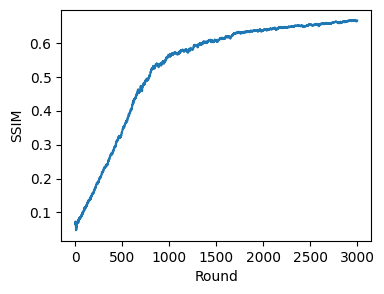

In [6]:
plt.figure(figsize=(4, 3))
plt.plot(avg_score["0"]['CI-Net']['ssim']['score'])
plt.ylabel("SSIM")
plt.xlabel("Round")
plt.show()

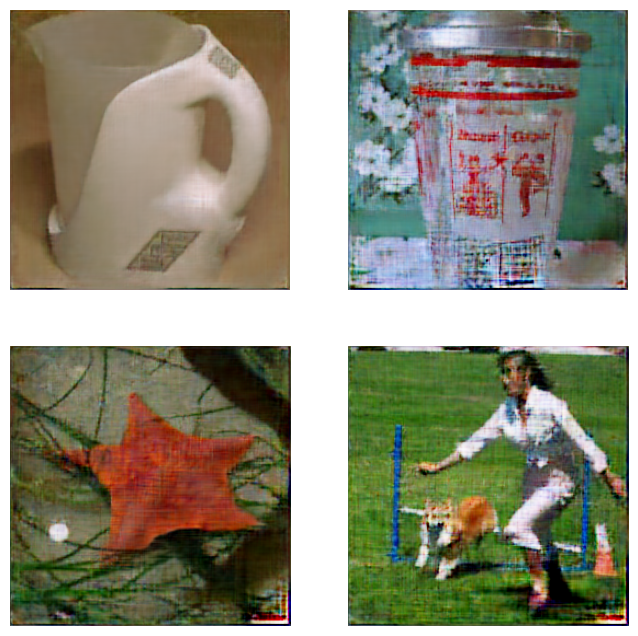

In [7]:
# Obtained Images
import numpy as np
horizontal = int(np.sqrt(size_batch))
vertical = int(np.sqrt(size_batch))
fig, axes = plt.subplots(horizontal, vertical, figsize=(6,6))
for i in range(horizontal):
    for j in range(vertical):
        axes[i,j].imshow(torch.clamp(reconstructed_image["0"]["image"]['CI-Net']['ssim']["timeline"][0][-1][horizontal*i+j],min = 0 ,max =1)\
                         .detach().cpu().permute(1,2,0))
        axes[i,j].axis('off')
plt.show()